In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Polimi/AN2DL Challenge/Homework1

Mounted at /gdrive
/gdrive/My Drive/Polimi/AN2DL Challenge/Homework1


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
#import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


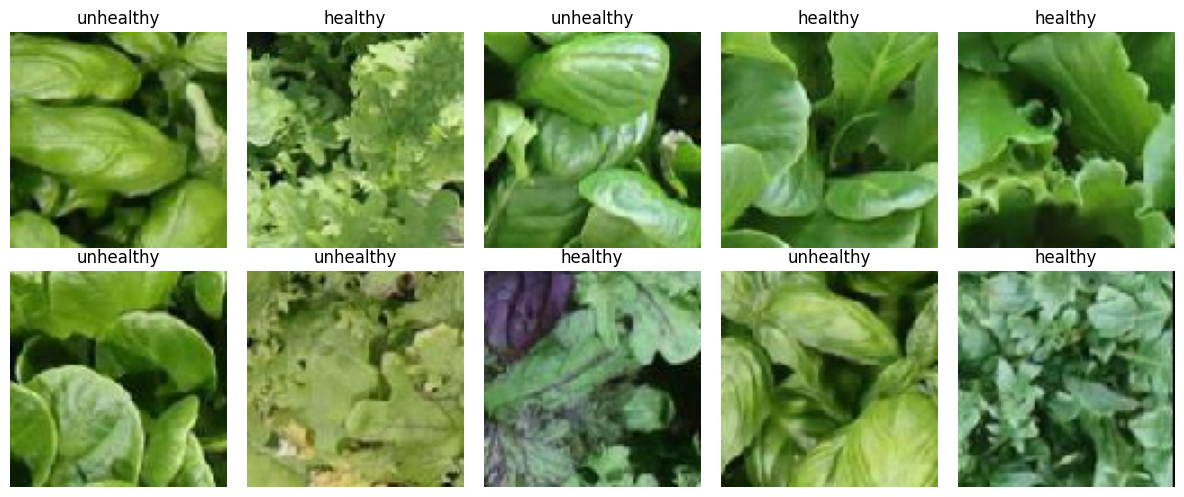

In [6]:
# Load the dataset from the npz file
data = np.load('public_data.npz', allow_pickle=True)

# Extract images and labels from the loaded data
images = data['data']
labels = data['labels']

num_images = len(images)

# Normalize the image data to the range [0, 1]
images = (images / 255).astype('float32')

# Plot 10 random images
plt.figure(figsize=(12, 5))
for i in range(10):
    image = np.random.randint(0, num_images)
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[image])
    plt.title(labels[image])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Assuming you have images (X) and labels (y)
X = images  # Your image data

# Transform labels into 0 (healthy) and 1 (unhealthy)
y = np.where(labels == "healthy", 0, 1)

# Remove duplicate images
X, indices = np.unique(X,axis=0, return_index=True)
y = y[indices]

# Remove Shrek (index found through image retrieval)
X = np.delete(X, 802, 0)
y = np.delete(y, 802, 0)

# Remove Trololo (index found through image retrieval)
X = np.delete(X, 4786, 0)
y = np.delete(y, 4786, 0)

# Convert to one-hot encoding
y = tfk.utils.to_categorical(y, num_classes=2)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1940, 96, 96, 3), y_train shape: (1940, 2)
X_val shape: (1455, 96, 96, 3), y_val shape: (1455, 2)
X_test shape: (1455, 96, 96, 3), y_test shape: (1455, 2)


In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

In [9]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Add data augmentation layers
# preprocessing = tf.keras.Sequential([
#         tfkl.RandomFlip("horizontal"),
#         tfkl.RandomRotation(0.2),
#         tfkl.RandomTranslation(0.2,0.2),
#         tfkl.RandomBrightness(0.5, value_range=(0,1)),
#         tfkl.RandomContrast(0.75),
#     ], name='preprocessing')

# preprocessing = preprocessing(inputs)


# Connect MobileNetV2 to the input
# x = mobile(preprocessing)
x = mobile(inputs)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [10]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True)]
).history

Epoch 1/200
61/61 [==============================] - 14s 63ms/step - loss: 0.6033 - accuracy: 0.7026 - val_loss: 0.4909 - val_accuracy: 0.7636
Epoch 2/200
61/61 [==============================] - 1s 23ms/step - loss: 0.4702 - accuracy: 0.7722 - val_loss: 0.4471 - val_accuracy: 0.7924
Epoch 3/200
61/61 [==============================] - 2s 30ms/step - loss: 0.4075 - accuracy: 0.7985 - val_loss: 0.4373 - val_accuracy: 0.7959
Epoch 4/200
61/61 [==============================] - 2s 25ms/step - loss: 0.3777 - accuracy: 0.8222 - val_loss: 0.4314 - val_accuracy: 0.8021
Epoch 5/200
61/61 [==============================] - 1s 22ms/step - loss: 0.3513 - accuracy: 0.8340 - val_loss: 0.4339 - val_accuracy: 0.7986
Epoch 6/200
61/61 [==============================] - 2s 27ms/step - loss: 0.3327 - accuracy: 0.8495 - val_loss: 0.4286 - val_accuracy: 0.8082
Epoch 7/200
61/61 [==============================] - 2s 28ms/step - loss: 0.3140 - accuracy: 0.8577 - val_loss: 0.4228 - val_accuracy: 0.8082
Epoch

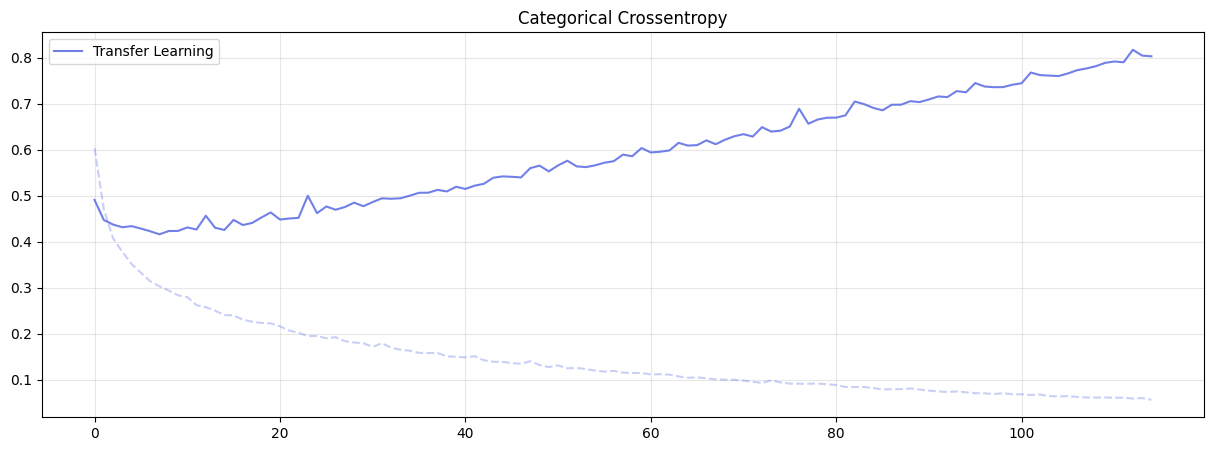

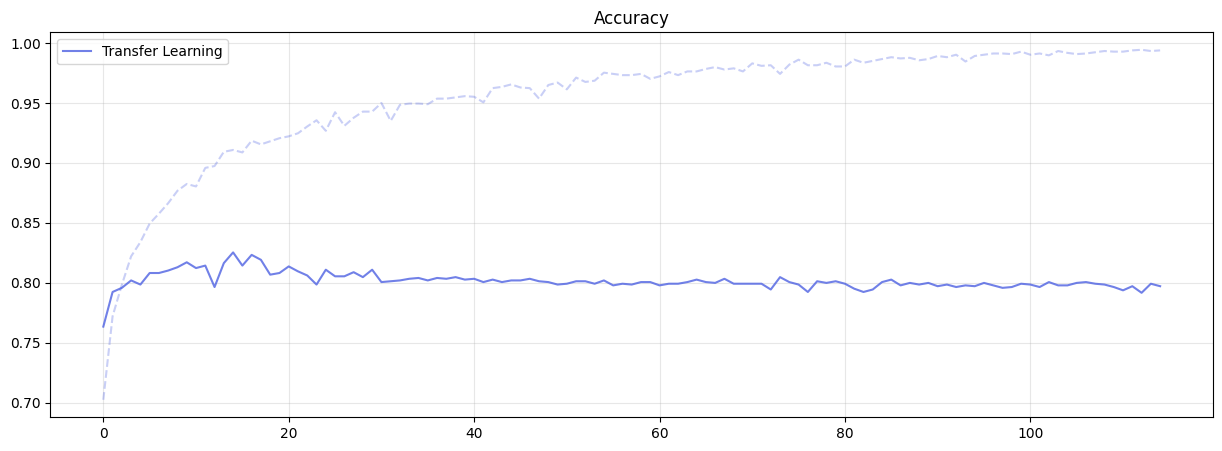

In [11]:
# Plot the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [12]:
# Save the best model
tl_model.save('CleanDataModel')

In [13]:
# Predict labels for the entire test set
predictions = tl_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)
print(predictions)
out = tf.argmax(predictions, axis=-1)
print(out)

Predictions Shape: (1455, 2)
[[8.9402717e-01 1.0597277e-01]
 [9.9942386e-01 5.7616265e-04]
 [3.3373618e-01 6.6626382e-01]
 ...
 [1.5643926e-01 8.4356076e-01]
 [8.7241381e-01 1.2758616e-01]
 [1.7485023e-02 9.8251498e-01]]
tf.Tensor([0 0 1 ... 1 0 1], shape=(1455,), dtype=int64)


In [14]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.7883
Precision: 0.7739
Recall: 0.7665
F1: 0.7698
